# Processing

In [1]:
import functools as func
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
geo = pd.read_csv('geo_params.csv')
sales = pd.read_csv('sales.csv')
sku = pd.read_csv('sku.csv')

In [3]:
sales.isna().sum() / sales.shape[0]

ID            0.00000
geoCluster    0.00000
SKU           0.00000
date          0.00000
price         0.83101
sales         0.83101
dtype: float64

## Merge

In [4]:
merge = sales.merge(sku, how='inner', left_on='SKU', right_on='SKU')
merge = merge.merge(geo, how='inner', left_on='geoCluster', right_on='geoCluster')
merge_tmp = merge.copy()
merge.head()

ID  geoCluster    SKU        date  price  sales      Category  \
0  RR27956459          92  32485  2021-07-05  38.29    4.0        Banana   
1  RR27956474          92  32549  2021-07-05  89.39    0.5    Grapefruit   
2  RR42800188          92  16649  2021-06-05  17.69    1.0  Water, still   
3  RR42800189          92  16649  2021-06-06    NaN    NaN  Water, still   
4  RR42800190          92  16649  2021-06-07    NaN    NaN  Water, still   

                                        Type  brandId  lagerUnitQuantity  \
0                             Banana — Plain      NaN                1.0   
1          Citrus fruit — Grapefruit — Plain      NaN                1.0   
2  Table water — PET — from 1 to 2 L — Still   1241.0                1.5   
3  Table water — PET — from 1 to 2 L — Still   1241.0                1.5   
4  Table water — PET — from 1 to 2 L — Still   1241.0                1.5   

   Units  trademark  countryOfOrigin            Group  cityId  
0    NaN        NaN              NaN  Tropical fruits       1  
1    NaN        NaN              NaN  Tropical fruits       1  
2    NaN     1323.0              1.0    Mineral water       1  
3    NaN     1323.0              1.0    Mineral water       1  
4    NaN     1323.0              1.0    Mineral water       1

In [5]:
def fill_na(df):
    df[['sales', 'price']] = df[['sales', 'price']].fillna(0)
    return df

merge_tmp = fill_na(merge_tmp)
merge_tmp.isna().sum()

ID                         0
geoCluster                 0
SKU                        0
date                       0
price                      0
sales                      0
Category              484142
Type                  484142
brandId              1990776
lagerUnitQuantity          0
Units                4605985
trademark            1057713
countryOfOrigin      2329612
Group                      0
cityId                     0
dtype: int64

In [6]:
merge = merge_tmp
merge['date'] = pd.to_datetime(merge.date).copy()
len(merge['Group'].unique())

5

In [7]:
groups = merge['Group'].unique()
print(groups)

['Tropical fruits' 'Mineral water' 'Yogurts' 'Bakery' 'Cheese']


# Visualization

In [8]:
def get_groups(df):
    df = df.groupby(by=['Group', 'date']).sum()
    return df

df= get_groups(merge)

<AxesSubplot:xlabel='date', ylabel='sales'>

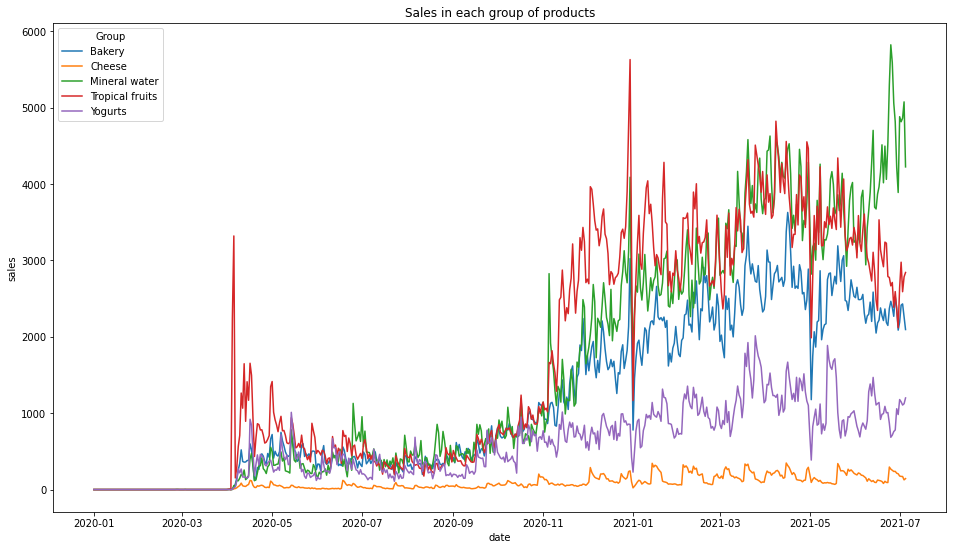

In [9]:
fig = plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df, x='date', y='sales', hue='Group'))
plt.title("Sales in each group of products")
plt.show()

<AxesSubplot:xlabel='date', ylabel='sales'>

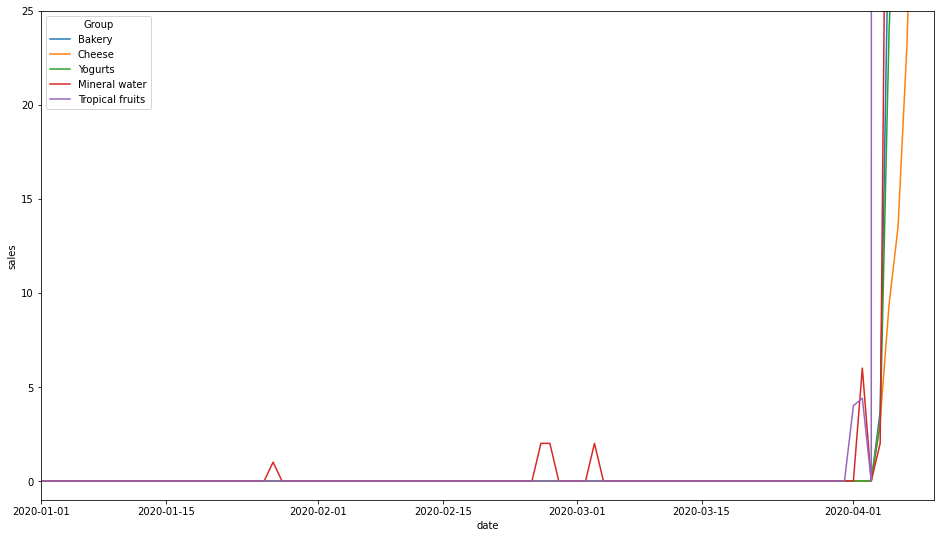

In [10]:
fig = plt.figure(figsize=(16, 9))
df = df.sort_values('date')
display(sns.lineplot(data=df, x='date', y='sales', hue='Group'))
plt.ylim([-1, 25])
plt.xlim([df.iloc[0].name[1], df.iloc[500].name[1]])
plt.show()

In [11]:
def remove_0(df):
    return df.iloc[459:]
df = remove_0(df)

<AxesSubplot:xlabel='date', ylabel='sales'>

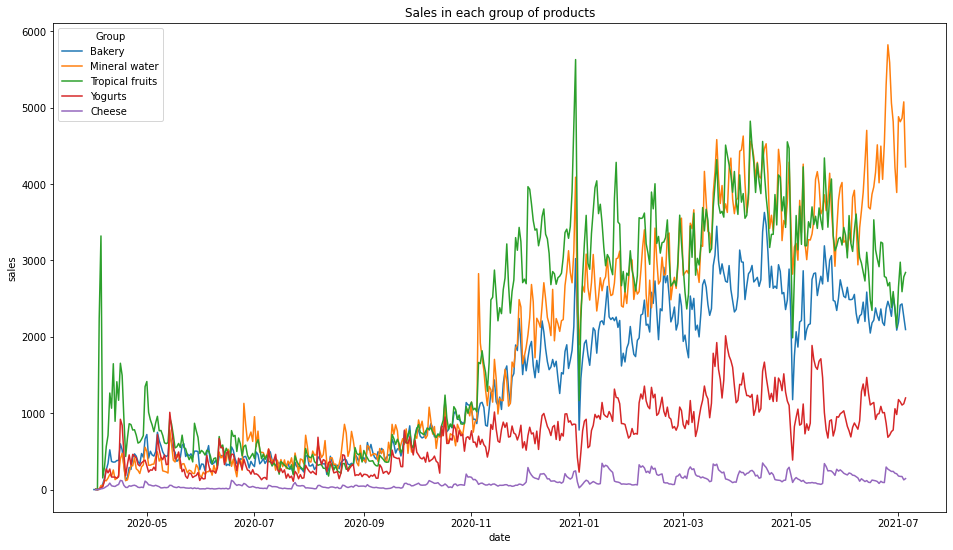

In [12]:
fig = plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df, x='date', y='sales', hue='Group'))
plt.title("Sales in each group of products")
plt.show()

## Fourier

Timedelta('459 days 00:00:00')

Timedelta('459 days 00:00:00')

Timedelta('459 days 00:00:00')

Timedelta('460 days 00:00:00')

Timedelta('459 days 00:00:00')

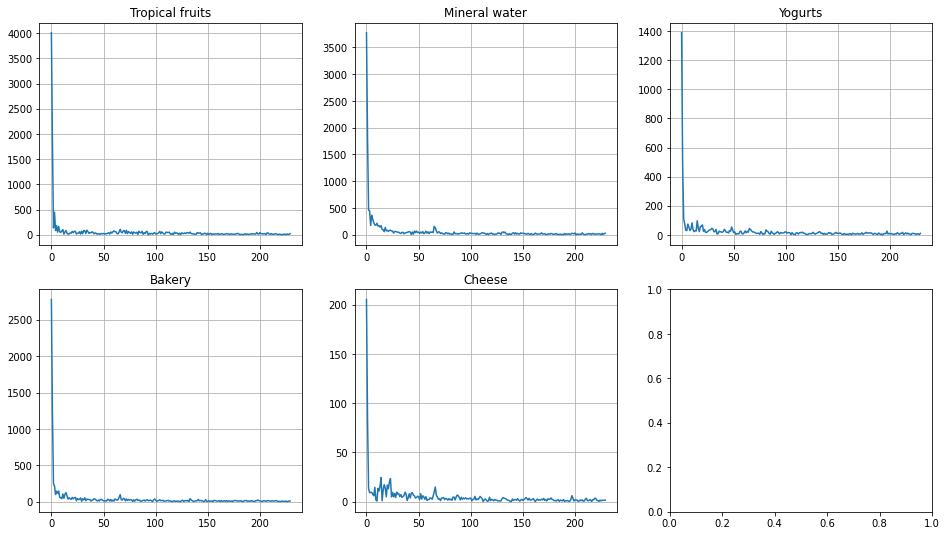

In [13]:
fig, axes = plt.subplots(2,3, figsize=(16, 9))
axes = list(axes[0]) + list(axes[1])
for ax, g in zip(axes, groups):
    df_group = df.loc[g]
    sales = df_group['sales']
    timedelta = df_group.index.max() - df_group.index.min()
    display(timedelta)
    N = sales.shape[0]
    yf = fft(np.array(sales))
    xf = fftfreq(N, 1/N)[:N//2]
    sns.lineplot(x=xf, y=2.0/N * np.abs(yf[0:N//2]), ax=ax)
    ax.set_title(g)
    ax.grid(True)

<AxesSubplot:title={'center':'Sales of each category by rolling'}, xlabel='date', ylabel='sales'>

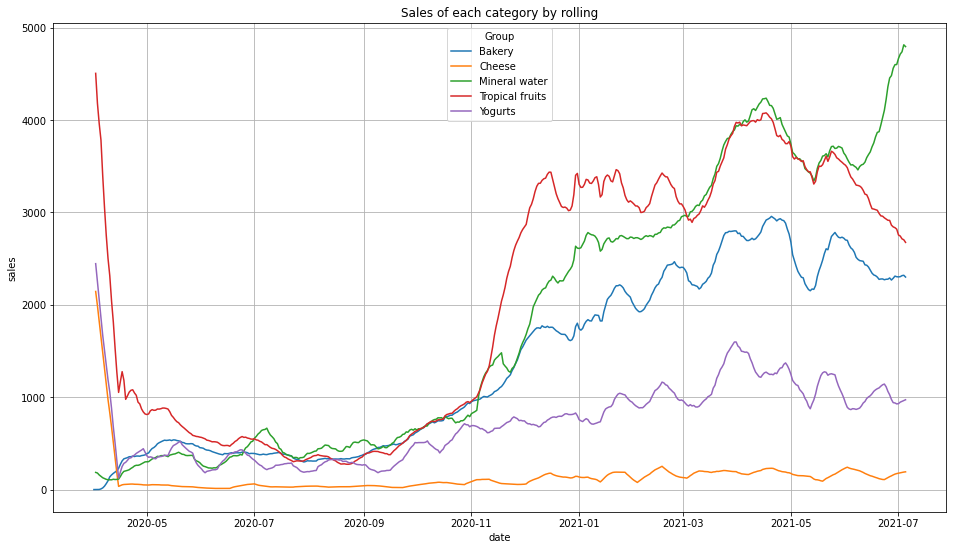

In [14]:
df = get_groups(df)
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title("Sales of each category by rolling")
display(sns.lineplot(data=df.rolling(14, min_periods=1).mean(), x='date', y='sales', hue='Group'))

In [15]:
x_fields = ['price']
y_field = ['sales']
df = df[x_fields + y_field]
df.describe()

price        sales
count    2301.000000  2301.000000
mean    22830.168292  1215.662794
std     24024.406362  1265.527777
min         0.000000     0.000000
25%      5865.190000   252.000000
50%     14426.620000   658.400000
75%     29854.940000  2200.300000
max    126219.650000  5821.000000

In [16]:
df.to_pickle('clean2.pickle')

In [17]:
df.head()

price  sales
Group  date                     
Bakery 2020-04-01    0.00    0.0
       2020-04-02    0.00    0.0
       2020-04-03    0.00    0.0
       2020-04-04  100.98    3.7
       2020-04-05  431.26   31.2

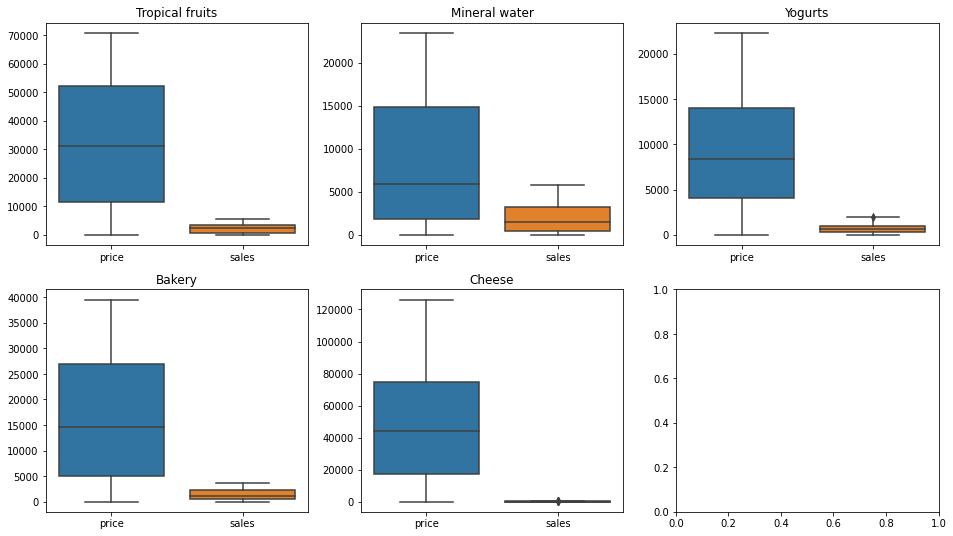

In [18]:
def ho_plot_group(df, func):
    fig, axes = plt.subplots(2,3, figsize=(16, 9))
    axes = list(axes[0]) + list(axes[1])
    res = []
    for ax, g in zip(axes, groups):
        df_tmp = df.loc[g]
        res.append((g, func(df_tmp, ax)))
        ax.set_title(g)
    return res
_ = ho_plot_group(df, lambda x, ax: sns.boxplot(data=x, ax=ax))

# ARIMA

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [20]:
df['sales']

Group    date      
Bakery   2020-04-01       0.0
         2020-04-02       0.0
         2020-04-03       0.0
         2020-04-04       3.7
         2020-04-05      31.2
                        ...  
Yogurts  2021-07-01    1178.0
         2021-07-02    1148.0
         2021-07-03    1106.0
         2021-07-04    1123.0
         2021-07-05    1199.0
Name: sales, Length: 2301, dtype: float64

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ori/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ori/.local/lib/python3.10/site-packages/statsmodels/bas

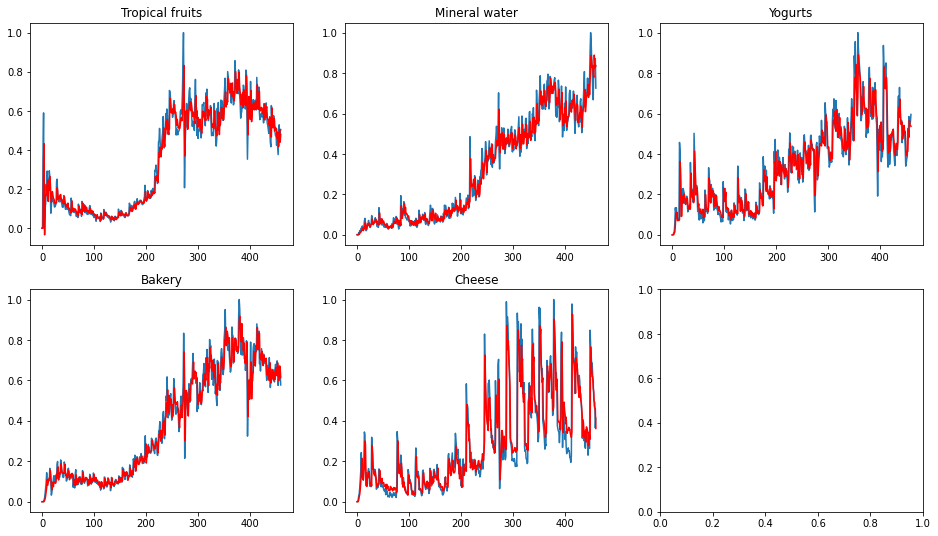

In [21]:
def arima_plot(df, ax):
    scaler = MinMaxScaler()
    sales = np.array(df['sales'])
    sales = np.array(sales).reshape(-1, 1)
    y = scaler.fit_transform(sales)
    model = ARIMA(y.squeeze(), order=(2,1,2))
    model_fit = model.fit()
    res = model_fit.predict(start=0, end=df['sales'].shape[0]-1)
    ax.plot(y)
    ax.plot(res, color="red")
    return res
predicts = ho_plot_group(df,arima_plot)

In [22]:
scaler = MinMaxScaler()
sales = np.array(df.loc['Bakery']['sales'])
sales = np.array(sales).reshape(-1, 1)
y = scaler.fit_transform(sales)
model = ARIMA(y.squeeze(), order=(2,1,2))
model_fit = model.fit()
res = model_fit.predict(start=0, end=400)
flatten = lambda x: func.reduce(lambda x, y : list(x)+ list(y), x)
y = flatten(y)
data = pd.DataFrame({'data' : np.concatenate((y, res)), 'Time': [i for i,_ in enumerate(y)] + [i for i, _ in enumerate(res)], 'Type': ['Real' for _ in y] + ['Output' for _  in res]})
fig = px.line(data, y='data', x='Time', color='Type')
fig.show()

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ori/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Metrics

In [23]:
def show_metric(metric, y_train, pred_train, y_test, pred_test):
    print("Train:" , metric(y_train, pred_train))
    print("Test:" , metric(y_test, pred_test))
    
for g, pred in dict(predicts).items():
    print(g, mean_squared_error(df.loc[g]['sales'], pred))

Tropical fruits 6026102.6624419475
Mineral water 5840366.120762365
Yogurts 656142.6889322869
Bakery 2847731.501056661
Cheese 17336.964841687462


# RNN Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import functools as func

2022-04-30 23:17:20.005183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 23:17:20.005203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
group = "Bakery"
pickle = 'clean2.pickle'

def get_df(pickle, train_ratio, is_train):
    df = pd.read_pickle(pickle)
    group_sales = df.groupby(level=0)['sales']
    df['new_sales'] = group_sales.shift(-7)
    df['sales4'] = group_sales.shift(4)
    df['sales7'] = group_sales.shift(7)
    df['sales10'] = group_sales.shift(10)
    df['sales14'] = group_sales.shift(14)
    df = df.fillna(0)
    df = df.loc[group].reset_index(drop=True)
    train_size = int(train_ratio * df.shape[0])
    df = df.iloc[:train_size] if is_train else df.iloc[train_size:].reset_index(drop=True)
    return df

df = get_df(pickle, 0.8, True)
df

price   sales  new_sales  sales4   sales7  sales10  sales14
0        0.00     0.0      257.4     0.0     0.00      0.0      0.0
1        0.00     0.0      342.2     0.0     0.00      0.0      0.0
2        0.00     0.0      519.9     0.0     0.00      0.0      0.0
3      100.98     3.7      367.6     0.0     0.00      0.0      0.0
4      431.26    31.2      359.1     0.0     0.00      0.0      0.0
..        ...     ...        ...     ...      ...      ...      ...
363  28974.24  2324.6     2666.5  2713.5  2953.90   3446.7   2280.0
364  31441.91  2356.8     2824.9  2931.4  2832.40   3003.3   2367.1
365  31669.36  2527.9     2856.0  2618.5  2725.84   2821.9   2928.9
366  36487.07  3134.8     2933.0  2471.6  2713.50   2953.9   3067.7
367  35347.84  2979.7     2717.4  2324.6  2931.40   2832.4   3446.7

[368 rows x 7 columns]

In [26]:
def transform(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    X = df[:, :-1]
    y = df[:, -1]
    return X.reshape(X.shape[0], 1, X.shape[1]), y
X, y = transform(df)

In [27]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(1, 6)))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               269312    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 285,825
Trainable params: 285,825
Non-trainable params: 0
_________________________________________________________________


2022-04-30 23:17:21.424948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 23:17:21.424971: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 23:17:21.424984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ori-lap): /proc/driver/nvidia/version does not exist
2022-04-30 23:17:21.425360: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model.fit(X, y, epochs=200)

Epoch 1/200
12/12 [==============================] - 1s 3ms/step - loss: 0.0592
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 3/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 6/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 11/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 13/200
12/12 [=================

12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 103/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 104/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 106/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 107/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 108/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 109/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 110/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 111/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 112/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 113/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 114/200
12/12 [=========

In [29]:
pred = model.predict(X)
flatten = lambda x: func.reduce(lambda x, y : list(x)+ list(y), x)
res = pd.DataFrame({'Pred' : flatten(pred), 'Real': y})
px.line(res)

In [30]:
df = get_df(pickle, 0.8, False)
X_test, y_test = transform(df)
X_test = X_test.reshape(93, 1, 6)
pred_test = model.predict(X_test)
res = pd.DataFrame({'Pred' : flatten(pred_test), 'Real': y_test})
px.line(res)


In [31]:
show_metric(mean_squared_error, y, pred, y_test, pred_test)

Train: 0.003722571556778367
Test: 0.03302618742969586


## Pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

geo = pd.read_csv('geo_params.csv')
sku = pd.read_csv('sku.csv')


class Merge(BaseEstimator, TransformerMixin):

    def __init__(self, geo, sku):
        self.geo = geo
        self.sku = sku

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        merge = X.merge(self.sku, how='inner', left_on='SKU', right_on='SKU')
        merge = merge.merge(self.geo, how='inner',
                            left_on='geoCluster', right_on='geoCluster')
        return merge


class FillNa(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X[['sales', 'price']] = X[['sales', 'price']].fillna(0)
        X['date'] = pd.to_datetime(X.date).copy()
        df = X.groupby(by=["Group", "date"]).sum()
        df = df.iloc[459:]
        return df


class GetFields(BaseEstimator, TransformerMixin):

    def __init__(self, fields):
        self.fields = fields

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        res = X[self.fields]
        return res

MINMAX = {g:MinMaxScaler() for g in groups}

class Shift(BaseEstimator, TransformerMixin):
    
    def __init__(self, groups):
        self.groups = groups

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        res = {}
        ys = {}
        X.to_pickle('X.pickle')
        for g in self.groups:
            df = X.loc[g]
            sales = df['sales']
            df['sales4'] = sales.shift(4).fillna(0)
            df['sales7'] = sales.shift(7).fillna(0)
            df['sales10'] = sales.shift(10).fillna(0)
            df['sales14'] = sales.shift(14).fillna(0)
            scaler = MinMaxScaler()
            MINMAX[g] = MINMAX[g].fit(np.array(df['price']).reshape(-1, 1))
            df['price'] = MINMAX[g].transform(np.array(df['price']).reshape(-1, 1))
            cols_not_price = [c for c in df.columns if c != 'price']
            df[cols_not_price] = scaler.fit_transform(df[cols_not_price])
            sales = df.sales
            df = df[[c for c in df.columns if c != 'sales']]
            res[g] = df
            ys[g] = sales
        return res, ys


transformer = FunctionTransformer(lambda x: x['price'])

pipe = Pipeline([
    ('merge', Merge(geo, sku)),
    ('fillna', FillNa()),
    ('getFields', GetFields(['price', 'sales'])),
    ('shift', Shift(groups)),
])


class MultiOutputRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, groups):
        self.groups = groups
        self.models={group: self.__create_model() for group in self.groups}

    def fit(self, X, y):
        for g in X:
            x = np.array(X[g])
            x = x.reshape(x.shape[0], 1, x.shape[1])
            self.models[g].fit(x, y[g], epochs=100)
        return self

    def predict(self, X):
        pred = {}
        for g in X:
            x = X[g]
            x = np.array(x)
            pred[g] = self.models[g].predict(x.reshape(x.shape[0], 1, x.shape[1]))
        return pred

    def __create_model(self):
        model=Sequential()
        model.add(LSTM(256, activation='relu', input_shape=(1, 5)))
        model.add(Dense(64))
        model.add(Dense(1))
        model.compile(optimizer= 'adam', loss = 'mse')
        model.build()
        return model


In [33]:
train=pd.read_csv('sales.csv')
train = train.sort_values('date')
res = pipe.fit(train)
res = pipe.transform(train)

In [34]:
preds = MultiOutputRegressor(groups).fit(res[0], res[1])
preds

Epoch 1/100
18/18 [==============================] - 1s 3ms/step - loss: 0.0527
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 12/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 13/100
18/18 [=================

18/18 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 12/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 14/100
18/18 [============================

18/18 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 11/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 15/100
18/18 [===========================

3/3 [==============================] - 0s 3ms/step - loss: 0.0454
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0426
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 11/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 12/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 13/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 14/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 15/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 16/100
3/3 [==============================] - 0s 3ms/step - loss

18/18 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 12/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 15/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 16/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 17/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 18/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 19/100
18/18 [=======================

MultiOutputRegressor(groups=array(['Tropical fruits', 'Mineral water', 'Yogurts', 'Bakery', 'Cheese'],
      dtype=object))

In [35]:
flatten = lambda x: func.reduce(lambda x, y : list(x)+ list(y), x)
for (g, X), y in zip(res[0].items(), res[1].values()):
    pred = preds.predict({g:X})
    pred = pred[g]
    data = pd.DataFrame({'Pred' : flatten(pred), 'Real': y})
    fig = px.line(data, title=g)
    display(f"{g} MEAN SQUARED ERROR:", mean_squared_error(y, flatten(pred)))
    fig.show()

'Tropical fruits MEAN SQUARED ERROR:'

0.0025335908255130187

'Mineral water MEAN SQUARED ERROR:'

0.0009890709010297889

'Yogurts MEAN SQUARED ERROR:'

0.0012559508443229657

'Bakery MEAN SQUARED ERROR:'

0.0028927506076492854

'Cheese MEAN SQUARED ERROR:'

0.0017901187348595506

## TEST

In [36]:
test = pd.read_csv('test.csv')
test = Merge(geo, sku).transform(test)

def groupby_date(X):
    X['price_filled'] = X['price_filled'].fillna(0)
    X['date'] = pd.to_datetime(X.date).copy()
    X = X.groupby(by=["Group", "date"]).sum()
    X = X[[c for c in X.columns if c != 'sales']]
    res = {}
    for g in groups:
        res[g] = MINMAX[g].transform(np.array(X.loc[g]['price_filled']).reshape(-1, 1))
    return res
    
X_test = groupby_date(test)
X_test

{'Tropical fruits': array([[3.86405816],
        [3.87568451],
        [3.90381411],
        [3.91383653],
        [3.92148579],
        [3.93382175],
        [3.94888488],
        [3.96027498],
        [3.98494675],
        [3.98774256],
        [3.97279423],
        [3.96878058],
        [3.95858871],
        [3.96504866]]),
 'Mineral water': array([[3.14028932],
        [3.17479542],
        [3.19393988],
        [3.21859281],
        [3.23609508],
        [3.25214458],
        [3.26146525],
        [3.26602406],
        [3.27444701],
        [3.26819961],
        [3.27335052],
        [3.27812003],
        [3.28086   ],
        [3.28961795]]),
 'Yogurts': array([[4.92869554],
        [4.94159666],
        [4.91129766],
        [4.89664645],
        [4.89141545],
        [4.88716447],
        [4.88431034],
        [4.89591714],
        [4.90192089],
        [4.92843811],
        [4.95353073],
        [4.97449101],
        [4.99115734],
        [5.00427873]]),
 'Bakery': array([[5.31

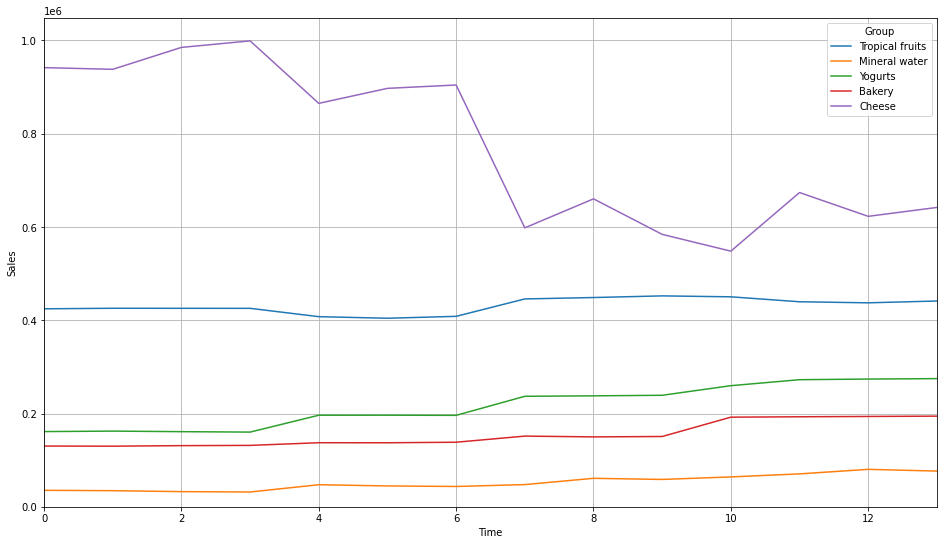

In [37]:
from collections import defaultdict

def predict_test(X, sales):
    isales = [3, 6, 9, 13]
    data=defaultdict(list)
    for g in X:
        last_sales = list(sales[g].iloc[-14:])
        for i, price in enumerate(X[g]):
            price = np.array([price])
            extension = np.array(last_sales).reshape(-1, 1)
            X_test = np.concatenate((price, extension[isales]), axis=0).squeeze()
            X_test = np.array([X_test.reshape(-1, 1)])
            out = preds.predict({g: X_test})[g].squeeze()
            last_sales.insert(0, out)
            last_sales.pop(-1)
            data['Group'].append(g)
            out = MINMAX[g].inverse_transform([[out]])
            out = out.squeeze()
            if g == 'Tropical fruits':
                out += 300000
            data['Sales'].append(out)
            data['Time'].append(i)
    data['Sales'] = np.array(data['Sales'])
    plt.figure(figsize=(16, 9))
    sns.lineplot(data=pd.DataFrame(data), x='Time', y='Sales', hue='Group')
    plt.grid(True)
    plt.xlim([0, 13])
    plt.ylim([0, max(data['Sales']) + 50000])
predict_test(X_test, res[1])

In [38]:
res[1]

{'Tropical fruits': date
 2020-01-01    0.000000
 2020-01-02    0.000000
 2020-01-03    0.000000
 2020-01-04    0.000000
 2020-01-05    0.000000
                 ...   
 2021-07-01    0.470690
 2021-07-02    0.528792
 2021-07-03    0.460116
 2021-07-04    0.494602
 2021-07-05    0.504808
 Name: sales, Length: 552, dtype: float64,
 'Mineral water': date
 2020-01-01    0.000000
 2020-01-02    0.000000
 2020-01-03    0.000000
 2020-01-04    0.000000
 2020-01-05    0.000000
                 ...   
 2021-07-01    0.838344
 2021-07-02    0.827006
 2021-07-03    0.835080
 2021-07-04    0.871672
 2021-07-05    0.725477
 Name: sales, Length: 552, dtype: float64,
 'Yogurts': date
 2020-01-01    0.000000
 2020-01-02    0.000000
 2020-01-03    0.000000
 2020-01-04    0.000000
 2020-01-05    0.000000
                 ...   
 2021-07-01    0.585196
 2021-07-02    0.570293
 2021-07-03    0.549429
 2021-07-04    0.557874
 2021-07-05    0.595628
 Name: sales, Length: 552, dtype: float64,
 'Bakery': dat